In [1]:
from owslib.wms import WebMapService

In [2]:
wms = WebMapService("https://isk.geobasis-bb.de/mapproxy/dgm/service/wms", version='1.3.0')

In [69]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetLegendGraphic']

In [75]:
wms.getOperationByName('GetLegendGraphic').

In [76]:
wms

OrderedDict([('dgm', <owslib.map.wms130.ContentMetadata at 0x153e9a37cf40>)])

In [20]:
list(wms.contents)

['dgm']

In [82]:
# @https://gis.stackexchange.com/questions/429209/how-to-get-more-information-about-the-legend-of-a-wms
def layer_report(service, layer_name):
  print(f"WMS general info:\n")
  print(f"WMS version: {service.identification.version}")
  print(f"WMS title: {service.identification.title}")
  print(f"WMS abstract: {service.identification.abstract}")
  print(f"Provider name: {service.provider.name}")
  print(f"Provider address: {service.provider.contact.address}")
  print(f"\nLayer info:\n")
  print('- Title: ', service.contents[layer_name].title)
  print('- BoundingBox: ', service.contents[layer_name].boundingBox)
  print('- BoundingBoxWGS84: ', service.contents[layer_name].boundingBoxWGS84)
  print('- CrsOptions: ', service[layer_name].crsOptions)
  print('- Format Options: ', service.getOperationByName('GetMap').formatOptions)
  print('- Layer styles: ', service[layer_name].styles)
  print('- Operations ', [op.name for op in service.operations])

In [83]:
layer_report(wms, "dgm")

WMS general info:

WMS version: 1.3.0
WMS title: WMS BB-BE DGM 1m Cache
WMS abstract: Dieser Web Map Service ist ein gekachelter Kartendienst zur schnellen Anzeige, welcher als Datengrundlage das digitale Geländemodell (Laserscan) mit der Bodenauflösung von 1m vom Gebiet Brandenburg mit Berlin hat.
Provider name: Landesvermessung und Geobasisinformation Brandenburg
Provider address: Heinrich-Mann-Allee 104 B

Layer info:

- Title:  Digitales Geländemodell 1m Bodenauflösung Cache Brandenburg mit Berlin (WMS)
- BoundingBox:  (11.152768795679583, 51.263517011631606, 15.392977959312176, 53.60940433664921, 'CRS:84')
- BoundingBoxWGS84:  (11.152768795679583, 51.263517011631606, 15.392977959312176, 53.60940433664921)
- CrsOptions:  ['EPSG:25832', 'EPSG:3034', 'EPSG:25833', 'EPSG:4839', 'EPSG:4326', 'EPSG:4258', 'EPSG:3857', 'EPSG:3035', 'EPSG:5650', 'EPSG:900913', 'EPSG:3045']
- Format Options:  ['image/jpeg', 'image/png', 'image/gif']
- Layer styles:  {'default': {'title': 'default', 'legend

In [3]:
bbox = (394168.38, 5796138.69, 394388.69, 5796390.61)

In [4]:
def __calculate_image_size(bbox, pixel_density):
        return([((bbox[2] - bbox[0]) / pixel_density), 
                ((bbox[3] - bbox[1]) / pixel_density)])

In [32]:
__calculate_image_size(bbox, 1)

[220.30999999999767, 251.9199999999255]

In [5]:
img = wms.getmap(layers = ["dgm"],
                srs = "EPSG:25833",
                bbox = bbox,
                size = __calculate_image_size(bbox, 1),
                format = "image/jpeg").read()

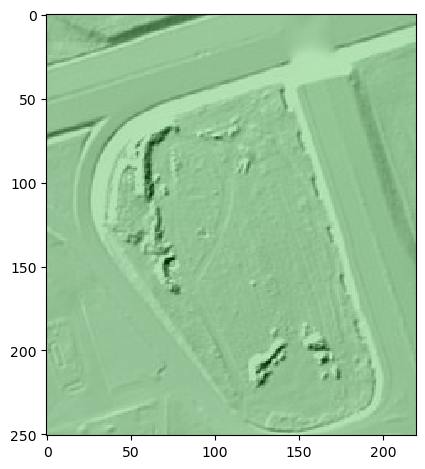

In [10]:
import io
import skimage
img_show = skimage.io.imread(io.BytesIO(img))
skimage.io.imshow(img_show)

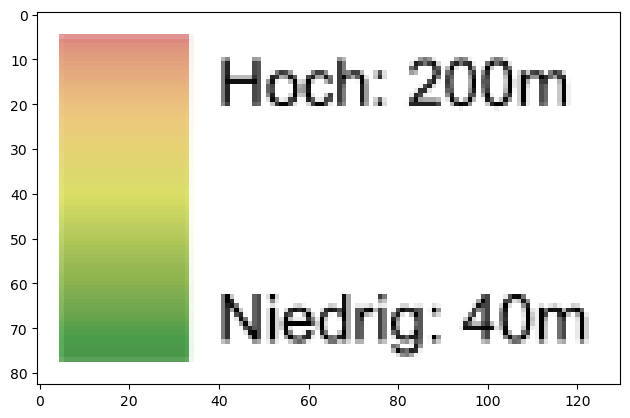

In [87]:
import requests
legend = requests.get("https://isk.geobasis-bb.de/mapproxy/dgm/service/wms?format=image%2Fpng&layer=dgm&sld_version=1.1.0&request=GetLegendGraphic&service=WMS&version=1.1.1") 
legend_show = skimage.io.imread(io.BytesIO(legend.content))
skimage.io.imshow(legend_show)

In [ ]:
# possible @TODO: match legend to get absolute height
legend_show[]

In [11]:
from skimage.color import rgb2gray
grayscale = rgb2gray(img_show)

In [8]:
skimage.io.imshow(grayscale)

NameError: name 'skimage' is not defined

In [12]:
import xarray
import numpy as np

tmp_xd = xarray.Dataset(data_vars = {"height": (["x", "y"], grayscale[::-1,::])},
                 coords = {"x": (["x"], np.arange(grayscale.shape[0]) * 1 + bbox[0]),
                           "y": (["y"], np.arange(grayscale.shape[1]) * 1 + bbox[1])})

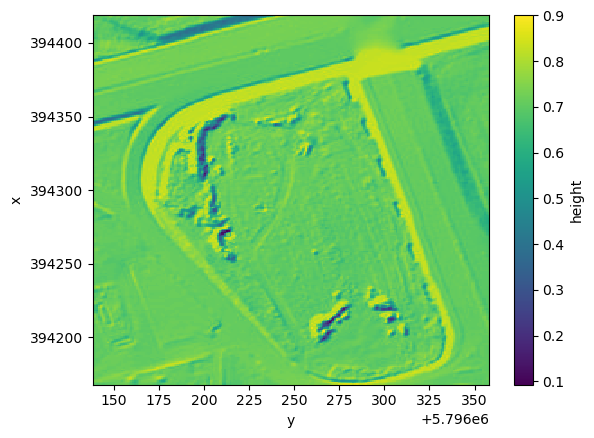

In [24]:
tmp_xd.height.plot()

In [25]:
tmp_xd.std()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    height   float64 0.06181

In [18]:
import xrspatial
tmp_xd_slope = xrspatial.slope(tmp_xd.height)
tmp_xd_slope.std() / (tmp_xd_slope.max() - tmp_xd_slope.min())

<xarray.DataArray 'slope' ()>
array(0.08794972, dtype=float32)

(array([4.6553e+04, 4.6480e+03, 1.3920e+03, 8.2800e+02, 4.6500e+02,
        2.1800e+02, 1.0200e+02, 4.4000e+01, 2.0000e+01, 1.2000e+01]),
 array([ 0.        ,  1.89055502,  3.78111005,  5.67166519,  7.5622201 ,
         9.452775  , 11.34333038, 13.23388481, 15.12444019, 17.01499557,
        18.90555   ]),
 <BarContainer object of 10 artists>)

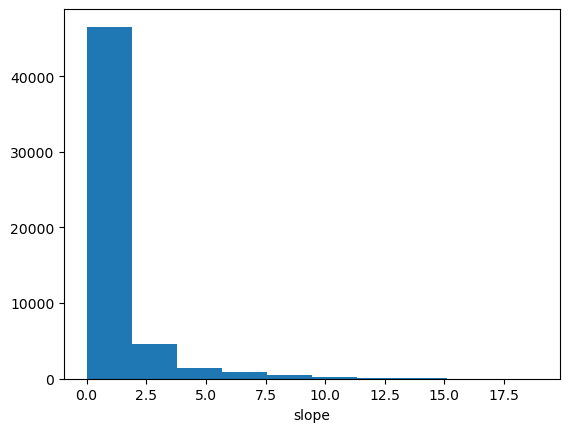

In [36]:
tmp_xd_slope.plot.hist()

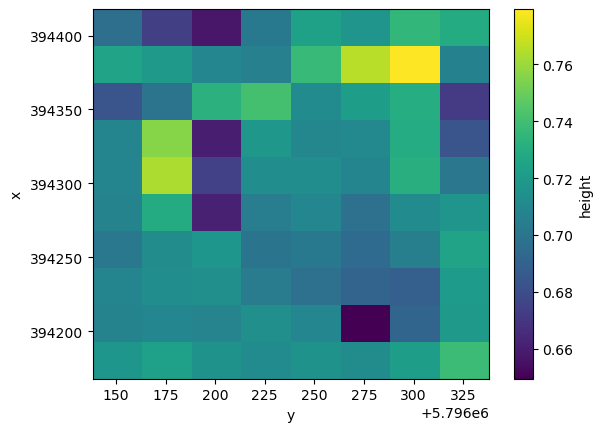

In [102]:
tmp_xd_coarsened = tmp_xd.coarsen({"x": 25, "y": 25}, boundary="trim").mean()
tmp_xd_coarsened.height.plot()

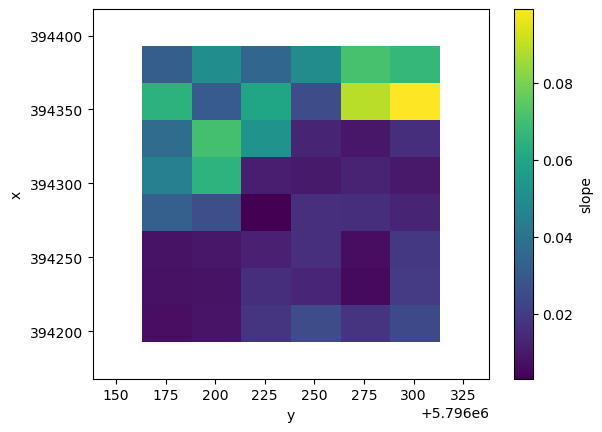

In [101]:
xrspatial.slope(tmp_xd_coarsened.height).plot()

# SRTM

In [109]:
tiles = [f"N{lat}E{lon}" for lat in np.arange(47, 54 + 1) for lon in ['{:03d}'.format(x) for x in np.arange(5, 15 + 1)]]


In [106]:
N 47 E 005
N 54 E015

'015'

In [167]:
execfile("/pfs/data5/home/tu/tu_tu/tu_zxobe27/ds_project/ds_project/research/notebooks/earthdata_auth.py")

In [159]:
it_tile = tiles[0]
link = f"https://e4ftl01.cr.usgs.gov/DP133/SRTM/SRTMGL1.003/2000.02.11/{it_tile}.SRTMGL1.hgt.zip"
filename = f"/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/SRTM/raw/{it_tile}.hgt.zip"

with requests.Session() as session:
    s.auth = (username, password)

    r1 = session.request('get', link)

    r = session.get(r1.url, auth=(username, password))
    
    if r.status_code == 200:
      with open(filename, 'wb') as out:
         for bits in r.iter_content():
            out.write(bits)

In [160]:
from zipfile import ZipFile
with ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/SRTM/raw/")

In [1]:
import xarray
import rioxarray
height = rioxarray.open_rasterio("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/SRTM/raw/N47E005.hgt")

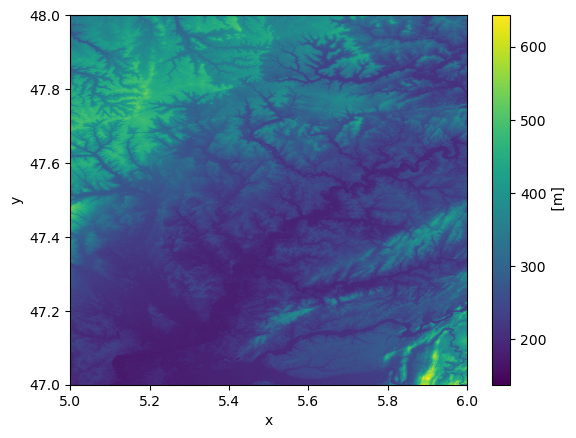

In [8]:
xarray.plot.imshow(height.squeeze("band", drop = True).drop("spatial_ref"))

In [4]:
height.rio.write_nodata(-100, inplace=True)
test = height.rio.reproject("EPSG:25833")

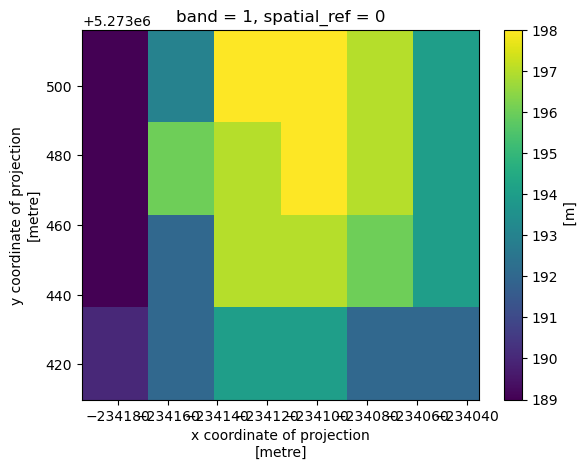

In [14]:
test.rio.clip_box(-234179.00, 5273427.06, -234040.05, 5273511.16).plot()


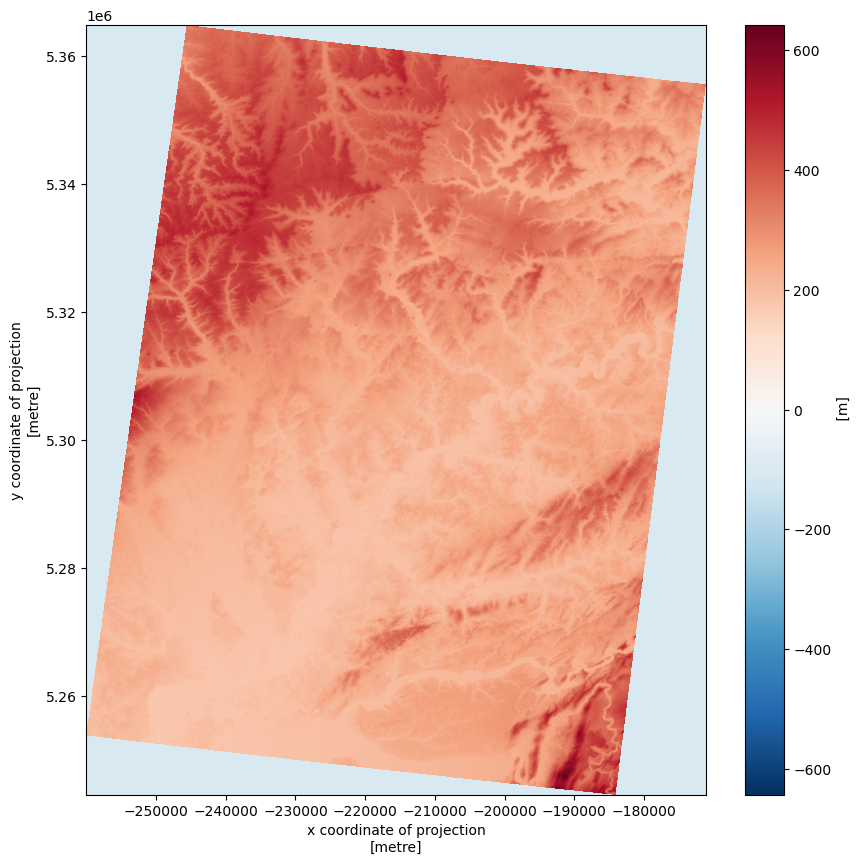

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10, 10))
xarray.plot.imshow(test.squeeze("band", drop = True).drop("spatial_ref"))
#ax.set_xlim([-210000, -209050])
#ax.set_ylim([5300000, 5300050])